# Analyzing Bias in Random Forests Using the CMNIST Dataset

## Obiettivo

L’obiettivo di questa tesi triennale è analizzare il fenomeno del bias nei modelli di Machine Learning, in particolare nel Random Forest. Per far questo utilizzeremo una derivazione del dataset MNIST in cui per ogni numero è associato un colore. In particolare utilizzeremo un dataset in cui il 95% delle immagini per ciascuna cifra presenta il colore corretto (anche detti *biased aligned*), mentre il restante 5% ha un colore associato a un’altra cifra (anche detti *biased conflicting*). Pertanto l'obiettivo è studiare le performance del modello Random Forest sulle immagini *biased aligned* e le performance su quelle *biased conflicting*, analizzando i risultati per ciascuna classe.

In una seconda fase, prenderemo delle feature estratte da una rete neurale pre-allenata (un vettore) per rispondere alla seguente domanda: Il Random Forest prende il bias indipendentemente dal tipo di classificatore? Oppure il bias può derivare dal tipo di rappresentazione del dato?

**Nota:** il vettore in questione non sarà più corrispondende ai pixel di un'immagine ma corrisponderà a delle caratteristiche imparate (in qualche modo) dalla rete neurale.

## Roadmap

Di seguito mostreremo la roadmap per raggiungere il nostro obiettivo:
1. Importazione dataset e definizione di training, validation e testing set. ✅
2. Inizializzazione Random Forest e training. ✅
3. (Tuning parametri Random Forest con validation set). ✅
4. Testing: 
    - Performance su *biased aligned* ✅
    - Performance su *biased conflicting* ✅
5. Importazione features da rete neurale pre-allenata.
6. Testing con features.
7. Conclusioni.

## Imports

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

## Importazione dataset

Prima di importare il dataset abbiamo bisogno di definire chiaramente il tipo di dato su cui andremo a lavorare. Il dataset è composto da immagini, pertano utilizzeremo la libreria *opencv* per andare a leggere ciascuna immagine che sarà di dimensione 28x28x3, dove 28x28 sono il numero di pixel e 3 sono i canali RGB di ciascuna immagine. 

Dal momento che il modello Random Forest lavora esclusivamente su istanze descritte da vettori e non da matrici, avremo bisogno di eseguire il *flatten* su ciascuna immagine così da avere un vettore 2352x1. Eseguendo questa operazione su ciascuna immagine otterremo il nostro input per il Random Forest. 

Per quanto riguarda i valori di output (e quindi la classificazione prodotta dal nostro modello), avremo bisogno di due liste:
- Y: corrisponde alle etichette di classe dell'oggetto di input (per esempio se l'immagine è uno 0, nella Y vi sarà uno 0)
- Y_bias: descrive la presenza o assenza di bias per ciascun oggetto di input, in particolare conterrà il valore relativo al colore assunto da quel numero.

Per definire tali liste andremo ad analizzare il nome del file di ciascuna immagine, il quale formate è il seguente "x_y_z.png", dove:
- x: è l'identificativo dell'immagine
- y: è l'etichetta di classe dell'immagine
- z: è il bias dell'immagine

Di conseguenza Y sarà composta dalla *y* di ciascuna immagine e Y_bias sarà composta dalla*z* di ciascuna immagine.

Infine, le directory del nostro dataset sono già strutturate in modo ottimo tra dataset di training, validation e testing, pertanto non avremo bisogno di dividere "manualmente" questi insiemi ma avremo bisogno solamente di leggere le giuste cartelle.

### Funzione per la lettura delle immagini

Per convenienza andremo a definire una funzione che possa essere chiamata su una cartella e restituisca rispettivamente X, Y e Y_bias:

In [2]:
def load_images_bias(folder_path):
    X = []
    Y = []
    Y_bias = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X.append(img.flatten())

        parts = filename.split('_')
        y = int(parts[1])
        y_bias = int(parts[2].split('.')[0])
        Y.append(y)
        Y_bias.append(y_bias)

    return np.array(X), np.array(Y), np.array(Y_bias)

Inoltre definiamo una funzione che calcoli il numero totale di immagini nelle cartelle visionate, in modo da controllare se tutte le immagini sono state importate correttamente:

In [3]:
def count_total_images(folder_path):
    return len([f for f in os.listdir(folder_path)])

### Definizione dataset di training

A questo punto andiamo a definire il dataset di training che conterrà tutte le immagini nelle cartelle *align* e *conflict*:

In [4]:
X_train = []
Y_train = []
Y_train_bias = []

In [5]:
total_images = 0
folder_path = 'cmnist/5pct/'
numbers = [str(i) + "/" for i in range(10)]

for parent_folder in ['align/', 'conflict/']:
    for number in numbers:
        X_batch, Y_batch, Y_bias_batch = load_images_bias(folder_path + parent_folder + number)
        X_train.extend(X_batch)        
        Y_train.extend(Y_batch)
        Y_train_bias.extend(Y_bias_batch)
        total_images += count_total_images(folder_path + parent_folder + number)

X_train = np.array(X_train)
Y_train = np.array(Y_train)
Y_train_bias = np.array(Y_train_bias)

Ora stampiamo le dimensioni ci ciascun insieme in modo da essere sicuri di aver definito correttamente l'insieme di training:

In [6]:
print(f"X_train shape      = {X_train.shape}")
print(f"Y_train shape      = {Y_train.shape}")
print(f"Y_train_bias shape = {Y_train_bias.shape}")
print(f"Total images       = {total_images}")

X_train shape      = (55000, 2352)
Y_train shape      = (55000,)
Y_train_bias shape = (55000,)
Total images       = 55000


## Definizione dataset di validation

A questo punto andiamo a definire il dataset di validation che conterrà tutte le immagini nella cartella "valid":

In [7]:
X_valid = []
Y_valid = []
Y_valid_bias = []

In [8]:
total_images = 0
folder_path = 'cmnist/5pct/valid/'

X_batch, Y_batch, Y_bias_batch = load_images_bias(folder_path)
X_valid.extend(X_batch)        
Y_valid.extend(Y_batch)
Y_valid_bias.extend(Y_bias_batch)
total_images = count_total_images(folder_path)

X_valid = np.array(X_valid)
Y_valid = np.array(Y_valid)
Y_valid_bias = np.array(Y_valid_bias)

Ora stampiamo le dimensioni ci ciascun insieme in modo da essere sicuri di aver definito correttamente l'insieme di validation:

In [9]:
print(f"X_valid shape      = {X_valid.shape}")
print(f"Y_valid shape      = {Y_valid.shape}")
print(f"Y_valid_bias shape = {Y_valid_bias.shape}")
print(f"Total images       = {total_images}")

X_valid shape      = (5000, 2352)
Y_valid shape      = (5000,)
Y_valid_bias shape = (5000,)
Total images       = 5000


## Definizione dataset di testing

A questo punto andiamo a definire il dataset di testing che conterrà tutte le immagini nella cartella "test".

**Nota:** dal momento che il nostro dataset è composto da diversi valori di correlazione, la cartella "test" si trova in un folder path diverso rispetto alle precedenti cartelle.

In [10]:
X_test = []
Y_test = []
Y_test_bias = []

In [11]:
total_images = 0
folder_path = 'cmnist/test/'

for number in numbers:
    X_batch, Y_batch, Y_bias_batch = load_images_bias(folder_path + number)
    X_test.extend(X_batch)        
    Y_test.extend(Y_batch)
    Y_test_bias.extend(Y_bias_batch)
    total_images += count_total_images(folder_path + number)

X_test = np.array(X_test)
Y_test = np.array(Y_test)
Y_test_bias = np.array(Y_test_bias)

Ora stampiamo le dimensioni ci ciascun insieme in modo da essere sicuri di aver definito correttamente l'insieme di testing:

In [12]:
print(f"Total images       = {total_images}")
print(f"X_test shape      = {X_test.shape}")
print(f"Y_test shape      = {Y_test.shape}")
print(f"Y_test_bias shape = {Y_test_bias.shape}")

Total images       = 10000
X_test shape      = (10000, 2352)
Y_test shape      = (10000,)
Y_test_bias shape = (10000,)


### Visualizzazione dataset

In questa sezione mostriamo una breve visualizzazione del dataset, mostrando le caratteristiche delle immagini con o senza bias. Iniziamo visualizzando il nostro dataset di training. Mostreremo come prima immagine l'immagine aligned di ogni numero, mentre le restanti immagini di ciascuna riga saranno *conflicting* rispetto a quel numero:

In [13]:
img_shape = (28, 28, 3)

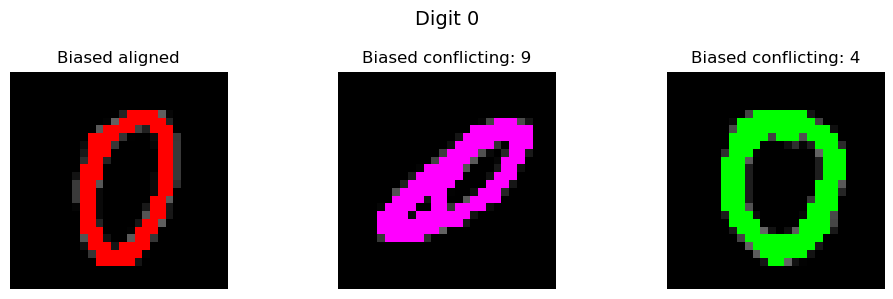

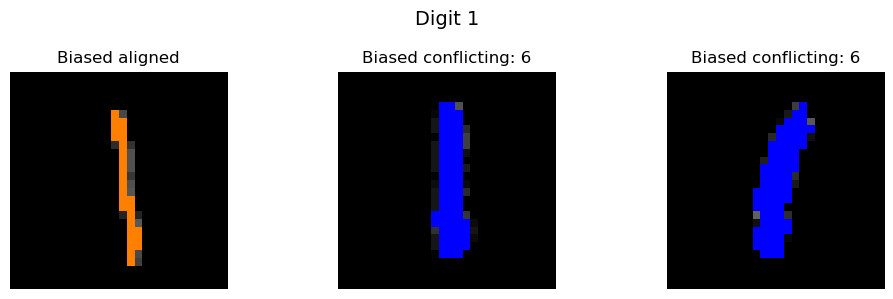

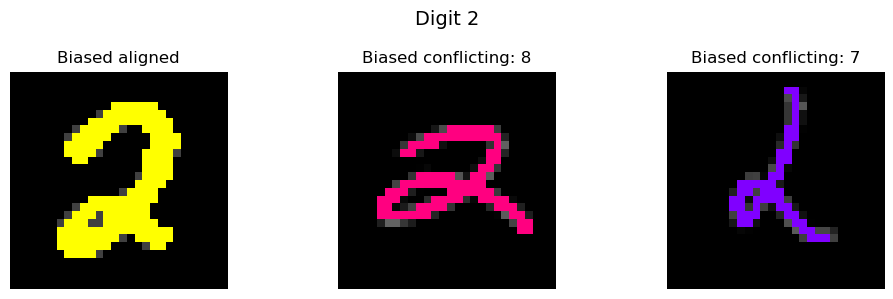

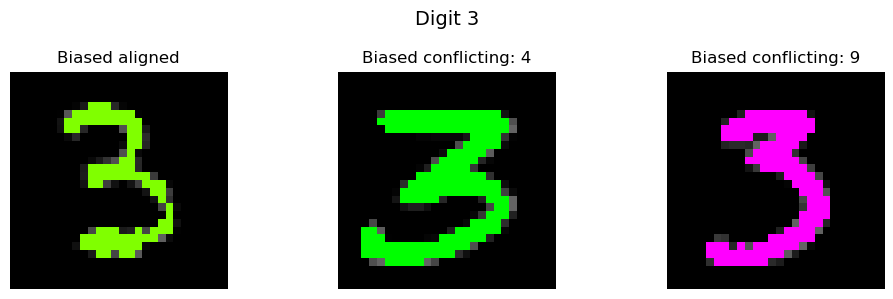

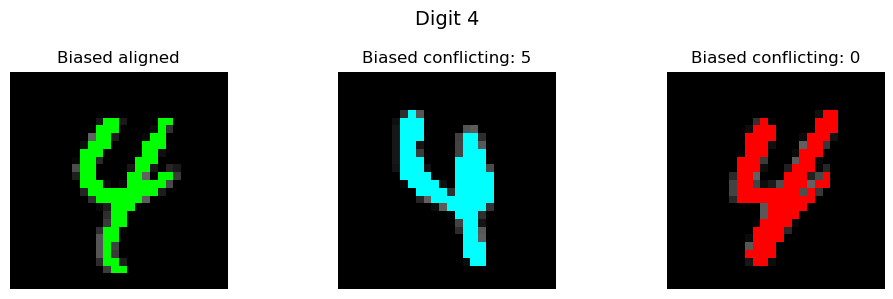

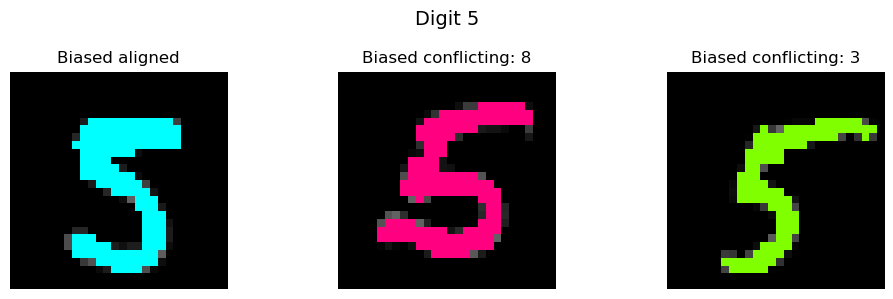

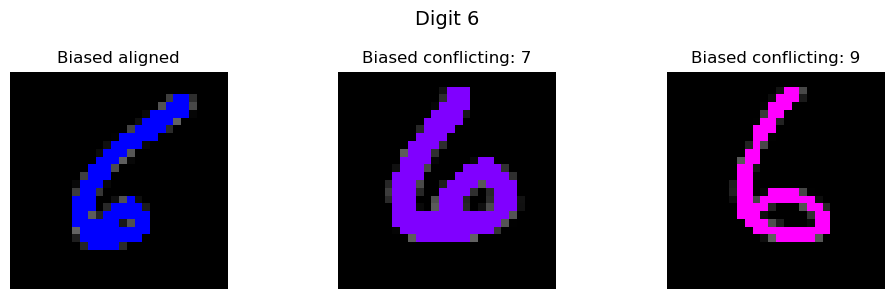

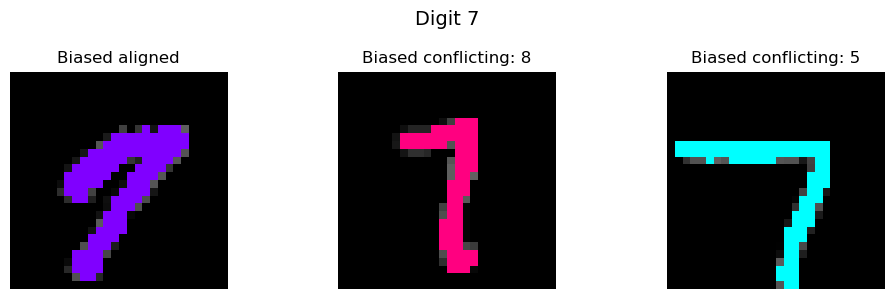

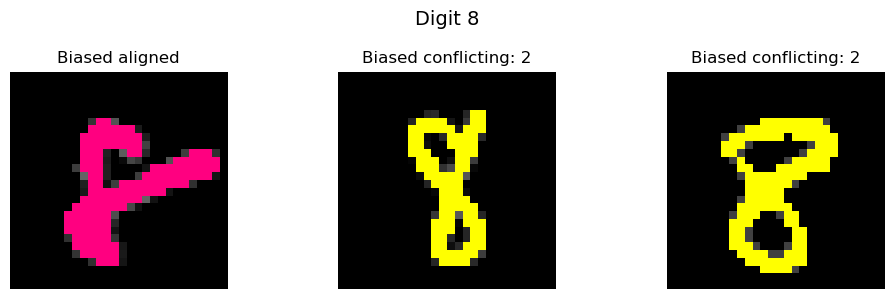

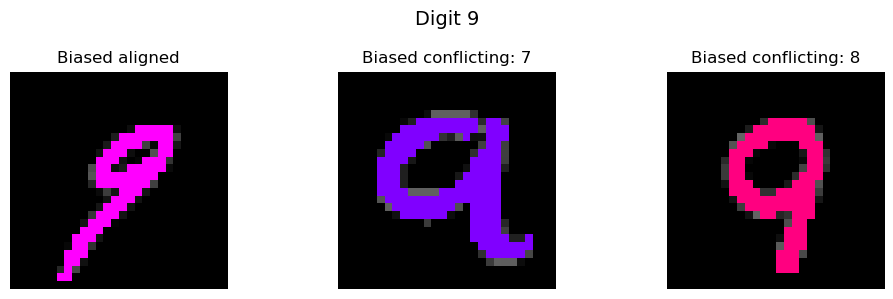

In [14]:
for digit in range(10):
    unbiased_idx = np.where((Y_train == digit) & (Y_train_bias == digit))[0]
    biased_idx = np.where((Y_train == digit) & (Y_train_bias != digit))[0]

    selected_indices = [unbiased_idx[0]] + list(biased_idx[:2])

    plt.figure(figsize=(10, 3))
    for i, idx in enumerate(selected_indices):
        img = X_train[idx].reshape(img_shape)
        plt.subplot(1, 3, i + 1)
        plt.imshow(img.astype(np.uint8))
        title = "Biased aligned" if i == 0 else f"Biased conflicting: {Y_train_bias[idx]}"
        plt.title(title)
        plt.axis('off')

    plt.suptitle(f"Digit {digit}", fontsize=14)
    plt.tight_layout()
    plt.show()

Invece per quanto riguarda il validation set e il training set, mostriamo 10 immagini per ciascun insieme: 

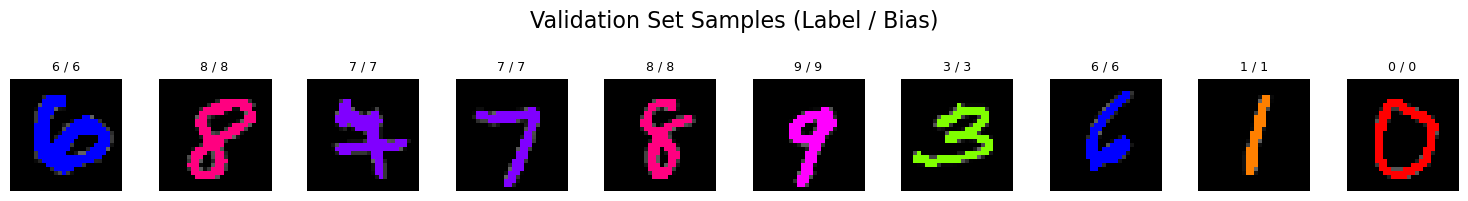

In [15]:
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
fig.suptitle("Validation Set Samples (Label / Bias)", fontsize=16)

random_indices = np.random.randint(0, X_valid.shape[0], size=10)

for plot_idx, img_idx in enumerate(random_indices):
    ax = axes[plot_idx]
    img = X_valid[img_idx].reshape(img_shape)
    ax.imshow(img.astype(np.uint8))
    ax.set_title(f"{Y_valid[img_idx]} / {Y_valid_bias[img_idx]}", fontsize=9)
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

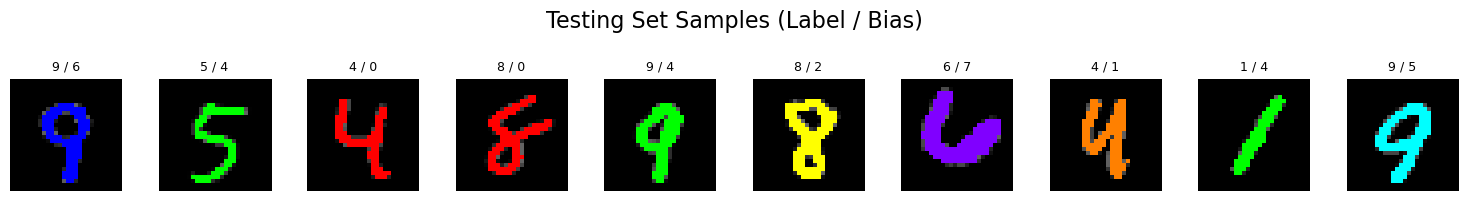

In [16]:
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
fig.suptitle("Testing Set Samples (Label / Bias)", fontsize=16)

random_indices = np.random.randint(0, X_test.shape[0], size=10)

for plot_idx, img_idx in enumerate(random_indices):
    ax = axes[plot_idx]
    img = X_test[img_idx].reshape(img_shape)
    ax.imshow(img.astype(np.uint8))
    ax.set_title(f"{Y_test[img_idx]} / {Y_test_bias[img_idx]}", fontsize=9)
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

## Random Forest

### Inizializzazione e Training

Random Forest è un metodo di apprendimento ensemble, che combina più alberi decisionali per ottenere un modello complessivo più stabile rispetto ai singoli alberi.

Al posto di far affidamento ad un solo albero decisionale (che solitamente è soggetto all'overfitting), un Random Forest costruisce una foresta di alberi. Ciascun di questi alberi viene addestrato su un sottoinsieme casuale del dataset di training, selezionato mediante la tecnica del bootstrap (campionamento con ripetizione, alcune istanze possono essere visionate più volte mentre altre mai). Ogni nodo dell'albero considera solo un sottoinsieme casuale delle caratteristiche (colonne nel nostro caso) disponibili per decidere la partizione ottimale. Questa casualità introduce varietà tra gli alberi e riduce la correlazione tra di essi, migliorando la generalizzazione.

Procediamo a definire il modello con iper-parametri, al momento, generici:

In [17]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

Successivamente andiamo ad allenarlo con il dataset di training definito nella sezione precedente:

In [18]:
model.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

### Validation

In questa sezione, attraverso il dataset di validation, andremo a definire in numero di estimatori definito al fine di ottenere il miglior risultati di precisione possibili.

**Nota:** gli altri iper-parametri per il modello Random Forest verranno testati in seguito.

Starting n_estimators tuning...
Training with 50 estimators...
Validation Accuracy for 50 estimators: 0.9690
Training with 100 estimators...
Validation Accuracy for 100 estimators: 0.9676
Training with 150 estimators...
Validation Accuracy for 150 estimators: 0.9684
Training with 200 estimators...
Validation Accuracy for 200 estimators: 0.9678
Training with 250 estimators...
Validation Accuracy for 250 estimators: 0.9682
Training with 300 estimators...
Validation Accuracy for 300 estimators: 0.9684


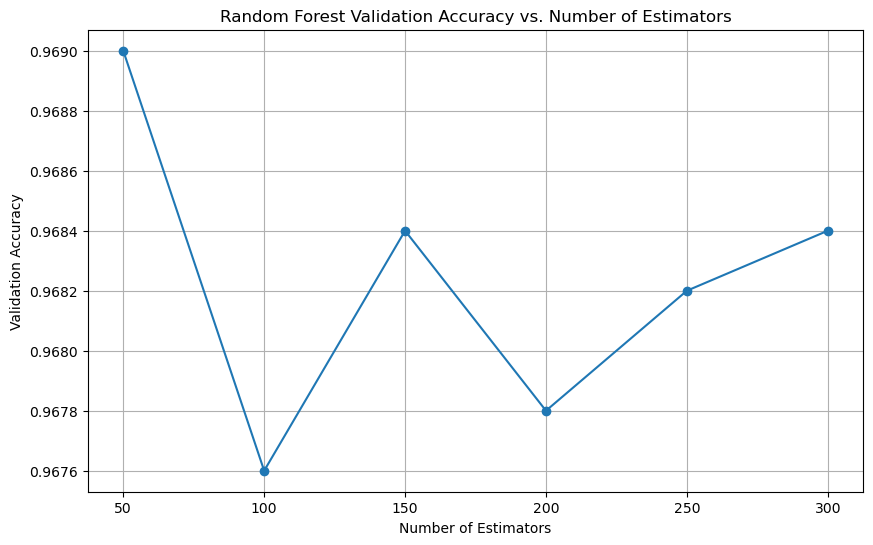

Best n_estimators from this test: 50 with accuracy: 0.9690


In [19]:
estimator_range = [50, 100, 150, 200, 250, 300]
validation_accuracies = []

print("Starting n_estimators tuning...")
for n_est in estimator_range:
    model_test = RandomForestClassifier(n_estimators=n_est, random_state=42, n_jobs=-1) # Use n_jobs=-1 to use all processors
    print(f"Training with {n_est} estimators...")
    model_test.fit(X_train, Y_train)
    y_valid_pred = model_test.predict(X_valid)
    accuracy = accuracy_score(Y_valid, y_valid_pred)
    validation_accuracies.append(accuracy)
    print(f"Validation Accuracy for {n_est} estimators: {accuracy:.4f}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(estimator_range, validation_accuracies, marker='o', linestyle='-')
plt.title('Random Forest Validation Accuracy vs. Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Validation Accuracy')
plt.xticks(estimator_range)
plt.grid(True)
plt.show()

best_n_estimators = estimator_range[np.argmax(validation_accuracies)]
print(f"Best n_estimators from this test: {best_n_estimators} with accuracy: {max(validation_accuracies):.4f}")

Osserviamo come il numero di estimatori, nel dataset di validation, non influenza in maniera significativa le performance del nostro modello. Pertanto continueremo ad utilizzare il modello con 100 estimatori.

### Testing

In questa sezione ci occuperemo di calcolare l'accuracy del modello su tre campioni distinti:
1. **Campione generale:** insieme di immagini contenente numeri biased aligned o biased conflicting.
2. **Campione biased aligned:** insieme di immagini biased aligned, ovvero immagini il cui colore è corretto rispetto all'etichetta di classe.
3. **Campione biased conflicting:** insieme di immagini biased conflicting, ovvero immagini il cui colore è diverso rispetto all'etichetta di classe.

L'accuratezza del modello viene calcolata confrontando le predizioni del modello con le etichette reali su un set di dati di test, ovvero ogni albero della foresta produce una predizione indipendente e la predizione finale per ogni istanza è ottenuta tramite voto di maggioranza.

Procediamo a definire i due insiemi di testing:

In [20]:
# Biased aligned sample
X_test_aligned = X_test[Y_test == Y_test_bias]
Y_test_aligned = Y_test[Y_test == Y_test_bias]
Y_test_bias_aligned = Y_test_bias[Y_test == Y_test_bias]

In [21]:
# Biased conflicting sample
X_test_conflicting = X_test[Y_test != Y_test_bias]
Y_test_conflicting = Y_test[Y_test != Y_test_bias]
Y_test_bias_conflicting = Y_test_bias[Y_test != Y_test_bias]

A questo punto misuriamo l'accuracy del nostro modello sui tre campioni definiti precedentemente e analizziamo i risultati:

In [22]:
# General sample
y_pred = model.predict(X_test)

In [23]:
# Biased aligned sample
y_pred_aligned = model.predict(X_test_aligned)

In [24]:
# Biased conflicting sample
y_pred_conflicting = model.predict(X_test_conflicting)

In [25]:
print(f"Accuracy on general sample: {accuracy_score(Y_test, y_pred):.5f}")
print(f"Accuracy on biased aligned sample: {accuracy_score(Y_test_aligned, y_pred_aligned):.5f}")
print(f"Accuracy on biased conflicting sample: {accuracy_score(Y_test_conflicting, y_pred_conflicting):.5f}")

Accuracy on general sample: 0.41300
Accuracy on biased aligned sample: 1.00000
Accuracy on biased conflicting sample: 0.34734


Possiamo osservare come il nostro modello sia estremamente influenzato dal bias del colore. Infatti, per tutte le immagini biased aligned la sua predizione sarà corretta (100% accuracy), questo suggerisce che il modello ha imparato ad associare fortemente il colore alla classe, cioè ha imparato il bias del dataset piuttosto che la forma reale della cifra. Mentre per le immagini biased conflicting la sua accuracy cala drasticamente, arrivando ad un 34% di predizione corretta nella classificazione delle immagini.

Per quanto riguarda l'accuracy generale, essa è abbastanza bassa, arrivando ad un 41% di precisione della classificazione. Questo può essere un indice di una difficoltà a generalizzare correttamente su dati con un bias.

In conclusione possiamo dire che il modello Random Forest ha fortemente imparato il bias del colore, piuttosto che le caratteristiche strutturali delle cifre.

Un'analisi più dettagliata può essere svolta con l'utilizzo di *classification_report* il quale indica:
- Precision: di tutte i numeri che il modello che ha classificato come appartenenti ad una determinata classe, quante lo erano veramente?
- Recall: di tutte i numeri che erano veramente di questa classe, quante il modello è riuscito ad identificare correttamente?
- F1-score: è la media armonica della precisione e della recall.
- Support: è il numero di numeri di quella classe nel set di dati su cui è stato calcolato il report.

In [26]:
print("\nClassification Report on general sample:\n", classification_report(Y_test, y_pred))


Classification Report on general sample:
               precision    recall  f1-score   support

           0       0.59      0.63      0.61       980
           1       0.76      0.74      0.75      1135
           2       0.33      0.34      0.33      1032
           3       0.33      0.35      0.34      1010
           4       0.32      0.30      0.31       982
           5       0.18      0.18      0.18       892
           6       0.41      0.39      0.40       958
           7       0.54      0.55      0.54      1028
           8       0.23      0.22      0.23       974
           9       0.34      0.35      0.35      1009

    accuracy                           0.41     10000
   macro avg       0.40      0.41      0.40     10000
weighted avg       0.41      0.41      0.41     10000



In [27]:
print("\nClassification Report on biased aligned sample:\n", classification_report(Y_test_aligned, y_pred_aligned))


Classification Report on biased aligned sample:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        92
           1       1.00      1.00      1.00       108
           2       1.00      1.00      1.00       118
           3       1.00      1.00      1.00       107
           4       1.00      1.00      1.00       104
           5       1.00      1.00      1.00        74
           6       1.00      1.00      1.00        96
           7       1.00      1.00      1.00       113
           8       1.00      1.00      1.00        94
           9       1.00      1.00      1.00       100

    accuracy                           1.00      1006
   macro avg       1.00      1.00      1.00      1006
weighted avg       1.00      1.00      1.00      1006



In [28]:
print("\nClassification Report on biased conflicting sample:\n", classification_report(Y_test_conflicting, y_pred_conflicting))


Classification Report on biased conflicting sample:
               precision    recall  f1-score   support

           0       0.55      0.59      0.57       888
           1       0.74      0.71      0.73      1027
           2       0.25      0.25      0.25       914
           3       0.26      0.27      0.27       903
           4       0.24      0.22      0.23       878
           5       0.11      0.10      0.11       818
           6       0.34      0.32      0.33       862
           7       0.48      0.50      0.49       915
           8       0.14      0.14      0.14       880
           9       0.27      0.28      0.28       909

    accuracy                           0.35      8994
   macro avg       0.34      0.34      0.34      8994
weighted avg       0.35      0.35      0.35      8994



### Visualizzazione errori

Di seguito mostreremo alcune predizioni errate da parte del nostro modello per accentuare l'osservazione fatta in precedenza, ovvero che il modello ha imparato il colore e non la forma del numero.

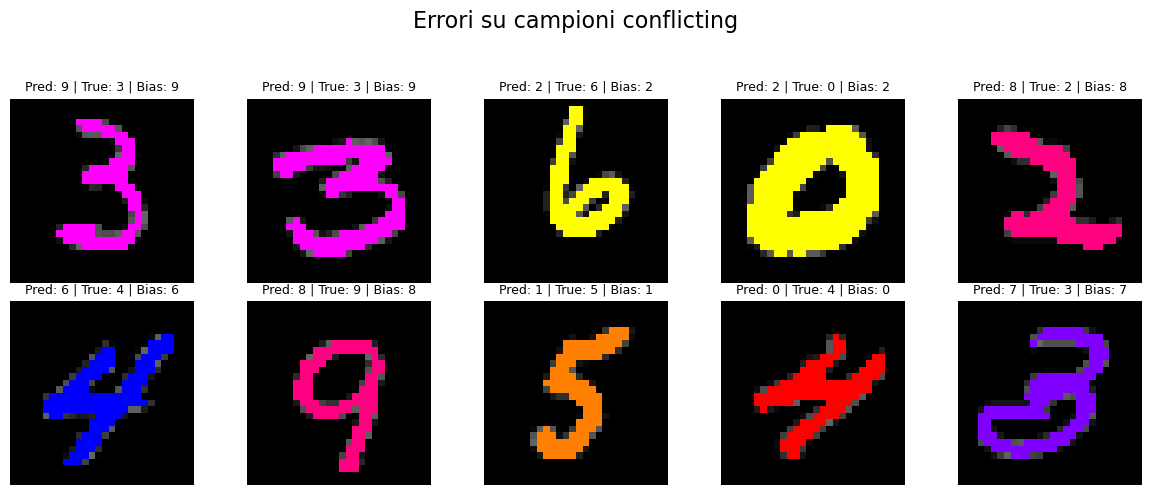

In [29]:
preds = model.predict(X_test)
wrong_idx = np.where((preds != Y_test) & (Y_test != Y_test_bias))[0]

selected_indices = wrong_idx[np.random.randint(0, len(wrong_idx), size=10)]

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle("Errori su campioni conflicting", fontsize=16)

for i, idx in enumerate(selected_indices):
    row = i // 5
    col = i % 5
    ax = axes[row, col]
    
    img = X_test[idx].reshape(img_shape).astype(np.uint8)
    ax.imshow(img)
    ax.set_title(f"Pred: {preds[idx]} | True: {Y_test[idx]} | Bias: {Y_test_bias[idx]}", fontsize=9)
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

Infine mostriamo la diffusion matrix per le predizioni del campione biased aligned e del campione biased conflicting:

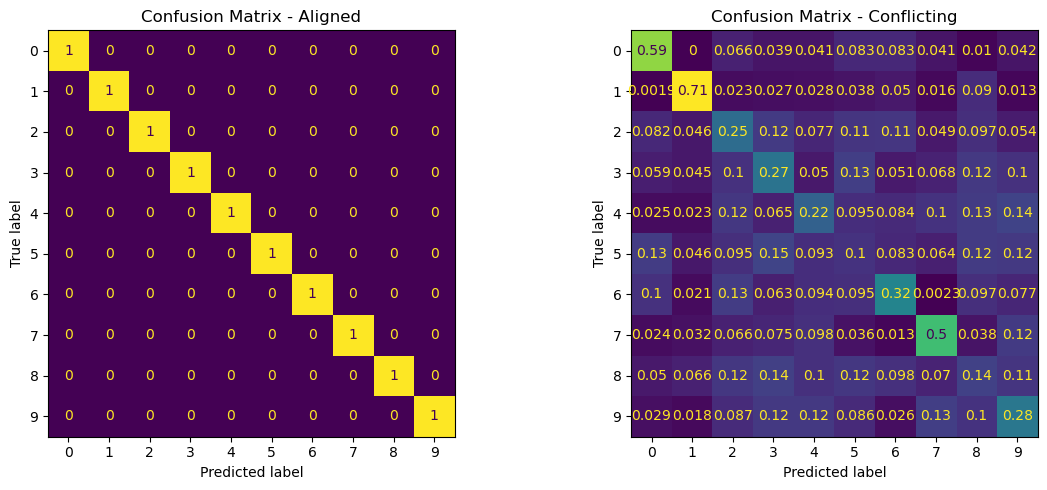

In [30]:
# Identifica gli indici dei campioni aligned e conflicting
aligned_idx = np.where(Y_test == Y_test_bias)[0]
conflicting_idx = np.where(Y_test != Y_test_bias)[0]

# Crea una figura con due sottoplot affiancati
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion matrix per i campioni aligned
ConfusionMatrixDisplay.from_predictions(
    Y_test[aligned_idx],
    preds[aligned_idx],
    normalize='true',
    ax=axes[0],
    colorbar=False
)
axes[0].set_title("Confusion Matrix - Aligned")

# Confusion matrix per i campioni conflicting
ConfusionMatrixDisplay.from_predictions(
    Y_test[conflicting_idx],
    preds[conflicting_idx],
    normalize='true',
    ax=axes[1],
    colorbar=False
)
axes[1].set_title("Confusion Matrix - Conflicting")

plt.tight_layout()
plt.show()

### Performance Random Forest su dataset senza bias

In questa sezione ci occuperemo brevemente di osservare le performance del modello Random Forest sul dataset MNIST, in modo da confermare la nostra tesi sull'influenza del bias. Procediamo a definire la funzione per la lettura delle immagini in bianco e nero:

In [31]:
def load_images_unbiased(folder_path):
    X = []
    Y = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_gray = cv2.resize(img_gray, (28, 28))
        img_gray[img_gray > 0] = 255
        X.append(img_gray.flatten())

        parts = filename.split('_')
        y = int(parts[1])
        Y.append(y)

    return np.array(X), np.array(Y)

Ora definiamo il dataset di tranining:

In [32]:
X_train_unbiased = []
Y_train_unbiased = []

In [33]:
folder_path = 'cmnist/5pct/'
numbers = [str(i) + "/" for i in range(10)]

for parent_folder in ['align/', 'conflict/']:
    for number in numbers:
        X_batch, Y_batch = load_images_unbiased(folder_path + parent_folder + number)
        X_train_unbiased.extend(X_batch)        
        Y_train_unbiased.extend(Y_batch)
        total_images += count_total_images(folder_path + parent_folder + number)

X_train_unbiased = np.array(X_train_unbiased)
Y_train_unbiased = np.array(Y_train_unbiased)

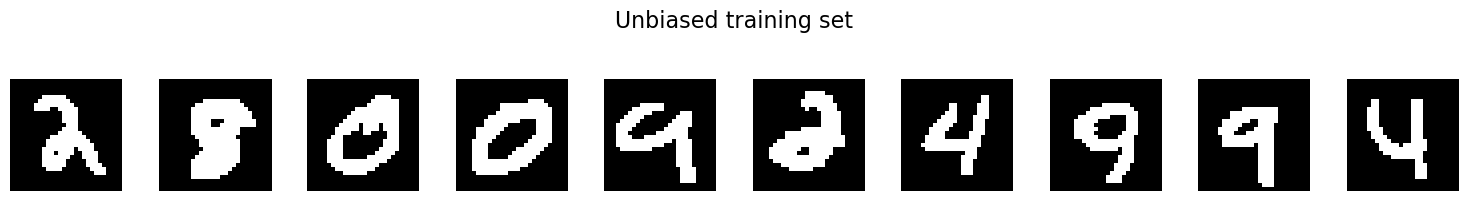

In [34]:
img_shape = (28,28)
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
fig.suptitle("Unbiased training set", fontsize=16)

random_indices = np.random.randint(0, X_train_unbiased.shape[0], size=10)

for plot_idx, img_idx in enumerate(random_indices):
    ax = axes[plot_idx]
    img = X_train_unbiased[img_idx].reshape(img_shape)
    ax.imshow(img.astype(np.uint8), cmap='gray')
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

A questo punto definiamo il dataset di testing:

In [35]:
X_test_unbiased = []
Y_test_unbiased = []

In [36]:
folder_path = 'cmnist/test/'

for number in numbers:
    X_batch, Y_batch = load_images_unbiased(folder_path + number)
    X_test_unbiased.extend(X_batch)
    Y_test_unbiased.extend(Y_batch)

X_test_unbiased = np.array(X_test_unbiased)
Y_test_unbiased = np.array(Y_test_unbiased)

Infine inizializziamo il modello e procediamo ad allenarlo sul dataset di training:

In [37]:
unbiased_model = RandomForestClassifier(n_estimators=100, random_state=42)
unbiased_model.fit(X_train_unbiased, Y_train_unbiased)

RandomForestClassifier(random_state=42)

Ora calcoliamo l'accuracy del nostro modello unbiased:

In [38]:
y_pred_un = unbiased_model.predict(X_test_unbiased)

In [39]:
print(f"Accuracy: {accuracy_score(Y_test_unbiased, y_pred_un):.5f}")

Accuracy: 0.96800


In [40]:
print("\nClassification Report on general sample:\n", classification_report(Y_test_unbiased, y_pred_un))


Classification Report on general sample:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.95      0.96      0.95      1010
           4       0.98      0.97      0.97       982
           5       0.98      0.96      0.97       892
           6       0.97      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.95      0.95      0.95       974
           9       0.96      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



Grazie ai risultati ottenuti, possiamo affermare che la bassa accuratezza del modello originario è dovuta al fatto che esso tende a basare le proprie decisioni sul colore, classificando i numeri principalmente in base al colore più frequentemente associato a ciascuna classe nel dataset. Al contrario, il modello unbiased, addestrato su immagini in scala di grigi, riesce a classificare correttamente i numeri riconoscendone la forma, mostrando quindi una maggiore resistenza al bias introdotto dal colore.